##  Homework 2 - Problem 5 : Handwritten digits

### Student: Dimitrios Tanoglidis

In [2]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    #plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

### Import the MNIST dataset

I downloaded the MNIST data set, which is actually consisted  out of a training set ($\sim 60000$ images) and a test set ($\sim 10000$ images). 

After reading the data, I will combine them into one set and split them into $60\%$ training, $20 \%$ development and $20 \%$ test sets.

In [3]:
data_train = np.float64(np.load("/Users/Dimitris/Desktop/Machine_Learning/HW2/train_images.npy"))
data_test = np.float64(np.load("/Users/Dimitris/Desktop/Machine_Learning/HW2/test_images.npy"))
labels_train = np.float32(np.load("/Users/Dimitris/Desktop/Machine_Learning/HW2/train_labels.npy"))
labels_test = np.float32(np.load("/Users/Dimitris/Desktop/Machine_Learning/HW2/test_labels.npy"))


# Combine all them into one dataset - divide the data by 255 to normalize the values
data = np.concatenate((data_train, data_test))/255.
labels = np.concatenate((labels_train, labels_test))

# Print their shapes to see
print(np.shape(data));print(np.shape(labels))
# Print also min and max values
print(np.min(data),np.max(data))

(70000, 784)
(70000, 1)
(0.0, 1.0)


And let's plot a subset (say the first twenty) of them...

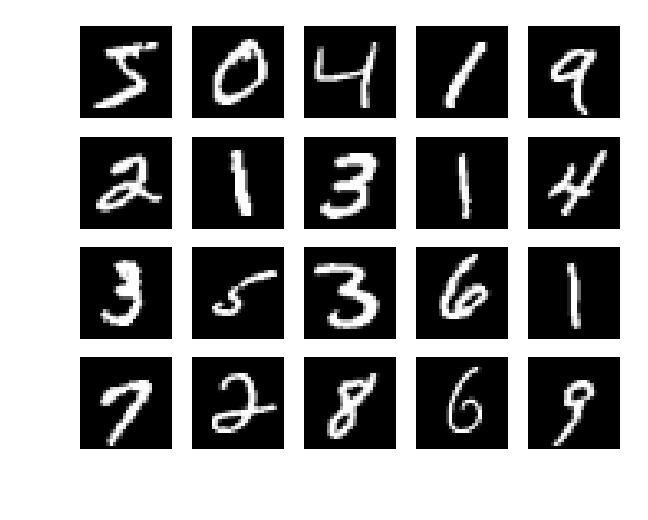

In [4]:
subset = data[0:20,:]
nrows = 4
ncols = 5

plt.figure(figsize=(ncols*0.7, nrows*0.7))

for i in xrange(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(subset[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

Now split the data into $60 \%$ training, $20 \%$ development and $20 \%$ test sets.

First split into $60 \%$-$40\%$ and then take the $40 \%$ and split it into two!

In [5]:
from sklearn.model_selection import train_test_split

# Split into 60% train set and 40% "rest" set - we will use it to further sub-split
data_train, data_rest, labels_train, labels_rest = train_test_split(data, labels, train_size = 0.60, random_state=42)

# Further split the rest set into development and test sets
data_devel, data_test, labels_devel, labels_test = train_test_split(data_rest, labels_rest, train_size = 0.50, random_state=42)

# Print their sizes:
print(np.shape(data_train),np.shape(data_devel), np.shape(data_test))

//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((42000, 784), (14000, 784), (14000, 784))


## Part 1: PCA

In this part I will perform the Principal Components Analysis (PCA) on the training data.


#### (a) Extract principal components

Here I will follow the more intuitive approach of eigendecomposition of the covariance matrix of our features.

In [6]:
# Subtract the means
data_train_new = np.zeros((42000,784))
data_means = np.zeros(784)
for i in range(784):
    data_means[i] = np.sum(data_train[:,i])/42000.0
    data_train_new[:,i] = data_train[:,i] - data_means[i]

# ===================================================
# Get the covariance matrix
cov_mat = np.cov(data_train_new.T)

# Get eigenvectors - eigenvalues
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Keep real part - imaginary part is zero as it should, but for some reason the output 
# gives a +0j imaginary part which is annoying
eig_vals = np.real(eig_vals)
eig_vecs = np.real(eig_vecs)

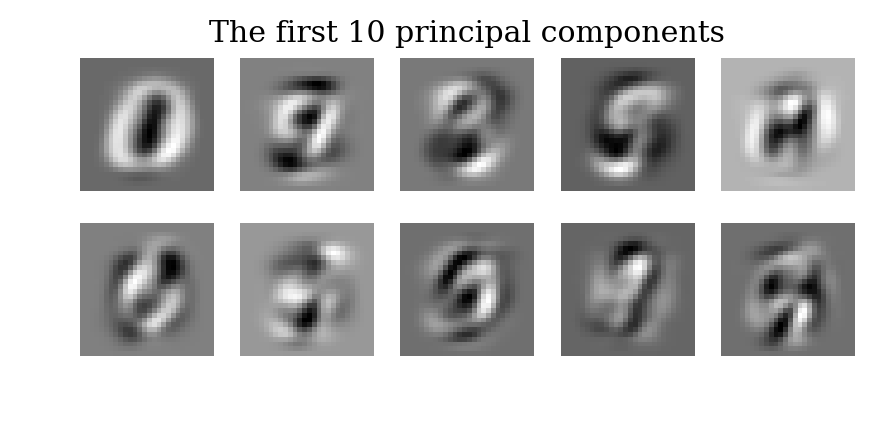

In [7]:
# Eigenvectors are the columnts of the matrix
eig_vecs_sub = (eig_vecs.T)[0:10]

nrows = 2
ncols = 5

plt.figure(figsize=(ncols, nrows))



for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("The first 10 principal components")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(eig_vecs_sub[i].reshape((28,28)), cmap='gray')
    plt.axis('off')


plt.axis('off')
plt.show()

#### (b) Plot variance

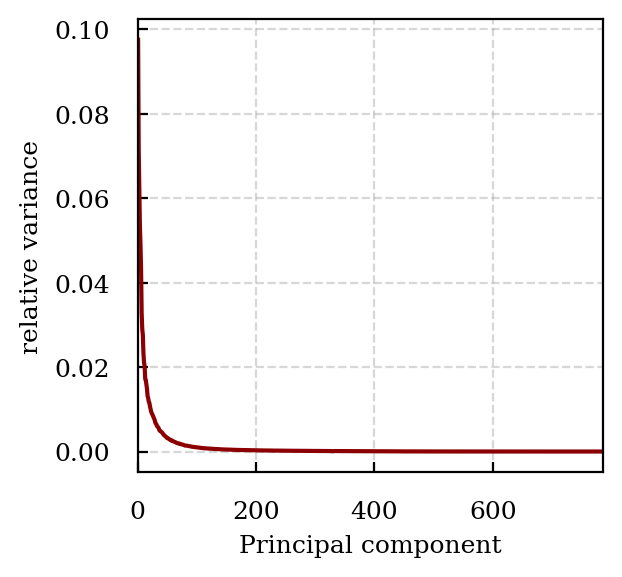

In [8]:
prin_comp = np.arange(1,785)

plt.figure(figsize=(3, 3))

plt.plot(prin_comp, eig_vals/np.sum(eig_vals), c = 'darkred')
plt.xlim(0,785)
plt.grid(ls='--',alpha=0.5)

plt.xlabel('Principal component');plt.ylabel('relative variance')
plt.show()

Let's also plot the variance up to the $\sim 100$th principal component


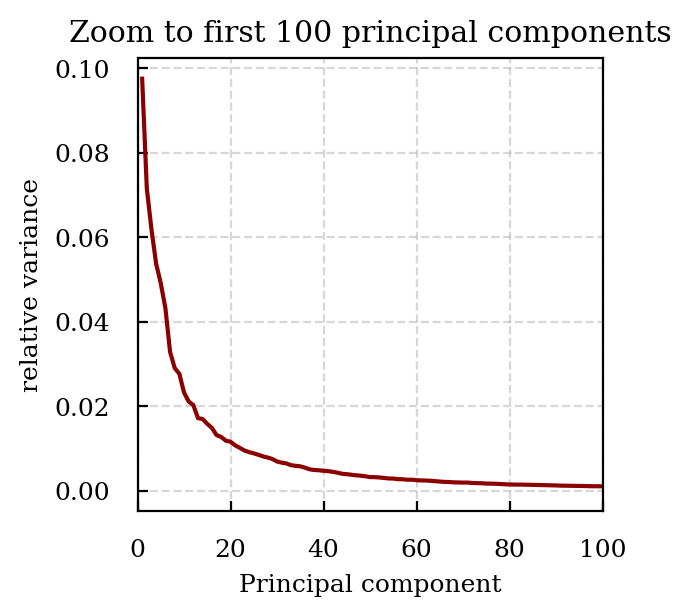

In [9]:
plt.figure(figsize=(3, 3))

plt.plot(prin_comp, eig_vals/np.sum(eig_vals), c = 'darkred')
plt.xlim(0,100)
plt.grid(ls='--',alpha=0.5)
plt.xlabel('Principal component');plt.ylabel('relative variance')
plt.title('Zoom to first 100 principal components')
plt.show()

#### (c) Dimension reduction

Let the $(784 \times 784)$ matrix of principal components be the matrix $U$:

Let also $\hat{U}$ the matrix created by keeping just the first $m$ principal components (eigenvectors). That matrix has, obviously, dimensions $(784 \times m)$. 

To get the projection, $Y_i$ of a data point $\tilde{X_i}$ (where $\tilde{X}_i = X_i - \bar{X}$), we perform:

\begin{equation}
Y_i = \hat{U}^T\tilde{X_i}
\end{equation}
  
$Y_i$ is a vector $(m \times 1)$, so the dimension has been reduced.

Then we can transform this back into a $784$-length vector by (also adding again the mean):

\begin{equation}
X_i^{approx} = \hat{U}Y_i + \bar{X} = \hat{U}\hat{U}^T\tilde{X_i} = P\tilde{X_i}+ \bar{X}
\end{equation}

Where we defined the projection-deprojection matrix as $P = \hat{U}\hat{U}^T$.

We will preform this for $m = [5,10,20,50,100,200]$ for a number of data points.

In [10]:
# First get the transpose of eig_vecs  
eigen_vec_mat = eig_vecs.T 

# Create the matrices with columns the first m principal components
U_5 = (eigen_vec_mat[0:5]).T
U_10 = (eigen_vec_mat[0:10]).T
U_20 = (eigen_vec_mat[0:20]).T
U_50 = (eigen_vec_mat[0:50]).T
U_100 = (eigen_vec_mat[0:100]).T
U_200 = (eigen_vec_mat[0:100]).T

# Create the projection matrices:
P_5 = np.matmul(U_5, U_5.T)
P_10 = np.matmul(U_10, U_10.T)
P_20 = np.matmul(U_20, U_20.T)
P_50 = np.matmul(U_50, U_50.T)
P_100 = np.matmul(U_100, U_100.T)
P_200 = np.matmul(U_100, U_200.T)

- For the first data point.

In [11]:
X_first = data_train_new[0]

# Create the projection/deprojections
X_pdj_5 = np.matmul(P_5,X_first) + data_means
X_pdj_10 = np.matmul(P_10,X_first) + data_means
X_pdj_20 = np.matmul(P_20,X_first) + data_means
X_pdj_50 = np.matmul(P_50,X_first) + data_means
X_pdj_100 = np.matmul(P_100,X_first) + data_means
X_pdj_200 = np.matmul(P_200,X_first) + data_means

X_projections = [X_pdj_5,X_pdj_10,X_pdj_20,X_pdj_50,X_pdj_100,X_pdj_200]

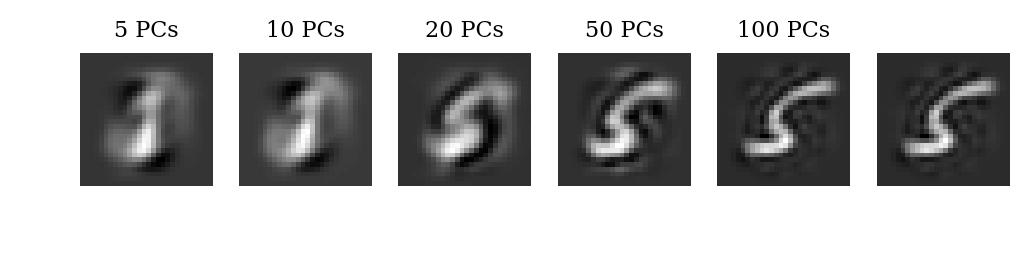

In [12]:
nrows = 1
ncols = 6
j = [5,10,20,50,100,200]

plt.figure(figsize=(ncols, nrows))
for i in xrange(nrows*ncols):
    plt.title("{0} PCs".format(j[i-1]), fontsize=8)
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(X_projections[i].reshape((28,28)), cmap='gray')
    plt.axis('off')

plt.axis('off')
plt.show()

- 10th data point

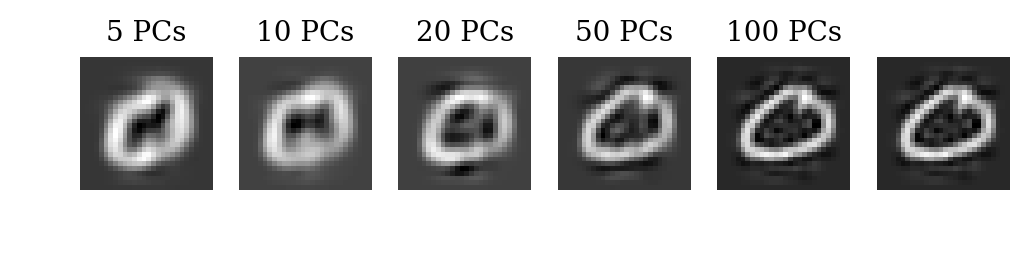

In [13]:
X_tenth = data_train_new[10]

# Create the projection/deprojections
X_pdj_5 = np.matmul(P_5,X_tenth) + data_means
X_pdj_10 = np.matmul(P_10,X_tenth) + data_means
X_pdj_20 = np.matmul(P_20,X_tenth) + data_means
X_pdj_50 = np.matmul(P_50,X_tenth) + data_means
X_pdj_100 = np.matmul(P_100,X_tenth) + data_means
X_pdj_200 = np.matmul(P_200,X_tenth) + data_means

X_projections = [X_pdj_5,X_pdj_10,X_pdj_20,X_pdj_50,X_pdj_100,X_pdj_200]


plt.figure(figsize=(ncols, nrows))
for i in xrange(nrows*ncols):
    plt.title("{0} PCs".format(j[i-1]), fontsize=10)
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(X_projections[i].reshape((28,28)), cmap='gray')
    plt.axis('off')

plt.axis('off')
plt.show()

- 20th data point

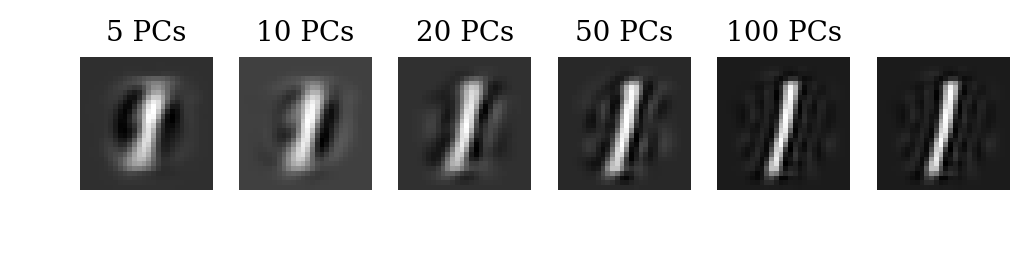

In [14]:
X_20th = data_train_new[20]
# Create the projection/deprojections
X_pdj_5 = np.matmul(P_5,X_20th) + data_means
X_pdj_10 = np.matmul(P_10,X_20th) + data_means
X_pdj_20 = np.matmul(P_20,X_20th) + data_means
X_pdj_50 = np.matmul(P_50,X_20th) + data_means
X_pdj_100 = np.matmul(P_100,X_20th) + data_means
X_pdj_200 = np.matmul(P_200,X_20th) + data_means
X_projections = [X_pdj_5,X_pdj_10,X_pdj_20,X_pdj_50,X_pdj_100,X_pdj_200]

plt.figure(figsize=(ncols, nrows))
for i in xrange(nrows*ncols):
    plt.title("{0} PCs".format(j[i-1]), fontsize=10)
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(X_projections[i].reshape((28,28)), cmap='gray')
    plt.axis('off')

plt.axis('off')
plt.show()



## Part 2: $k$-means

In [15]:
from sklearn.cluster import KMeans

kmeans_10 = KMeans(10) # 10 clusters
kmeans_20 = KMeans(20) # 20 clusters
kmeans_30 = KMeans(30) # 30 clusters

# Fit and predict labels
labels_10 = kmeans_10.fit_predict(data_train)
labels_20 = kmeans_20.fit_predict(data_train)
labels_30 = kmeans_30.fit_predict(data_train)

In [16]:
# Get the center clusters
centers_10 = kmeans_10.cluster_centers_
centers_20 = kmeans_20.cluster_centers_
centers_30 = kmeans_30.cluster_centers_

The centers lie in a $784$-dimensional space, I'm not sure how I can shwow them, since I cannot simply peak two features and show in that space.

Now let's assign each cluster to its majority label.

- Case: 10 clusters

In [17]:
def majority(arr):
    # Function that finds the the majority element
    # from an array that contains labels from 0 - 9
    
    # This array will contain the counts of each 
    # label (0-9) in the array "arr"
    count = np.zeros(10)
    for i in range(10):
        count[i] = len(arr[arr==i])
        
        
    # The majority element has the maximum counts
    maj = np.argmax(count)
    return maj

# Find majority label. Initialize
major = np.zeros(10)

for i in range(10):
    # Get the labels of the training set of 
    # the elements classified as belonging to the i-th cluster
    y_labels = labels_train[(labels_10==i)]
    major[i] = majority(y_labels)


Let's print the majority labels of the 10 clusters

In [18]:
print(major)

[7. 3. 6. 6. 0. 1. 4. 8. 2. 1.]


We see that in no cluster there is a majority of 5 or 9, so certainly the there is no "one-to-one" correspondace between clusters and numbers. Let's repeat for 20 and 30 clusters...

In [19]:
# Find majority label. Initialize
major_20 = np.zeros(20)
major_30 = np.zeros(30)

for i in range(20):
    # Get the labels of the training set of 
    # the elements classified as belonging to the i-th cluster
    y_labels = labels_train[(labels_10==i)]
    major_20[i] = majority(y_labels)
    

for i in range(30):
    # Get the labels of the training set of 
    # the elements classified as belonging to the i-th cluster
    y_labels = labels_train[(labels_10==i)]
    major_30[i] = majority(y_labels)

And let's print them...

- For 20 clusters

In [20]:
print(major_20)

[7. 3. 6. 6. 0. 1. 4. 8. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
print(major_30)

[7. 3. 6. 6. 0. 1. 4. 8. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


Interestingly enough, there is no improvement by increasing the number of clusters... Let's plot in the case of 10 clusters...

- Samples from the first cluster, with majority label "7"

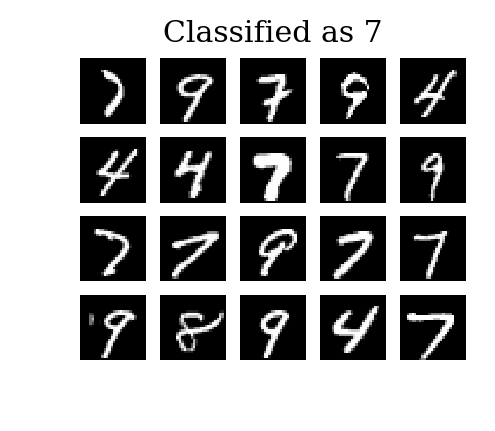

In [32]:
clust_1 = (data_train[(labels_10==0)])[0:20,:]

nrows = 4
ncols = 5

plt.figure(figsize=(ncols*0.5, nrows*0.5))

for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 7")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_1[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

- Second cluster, majority label "3" 

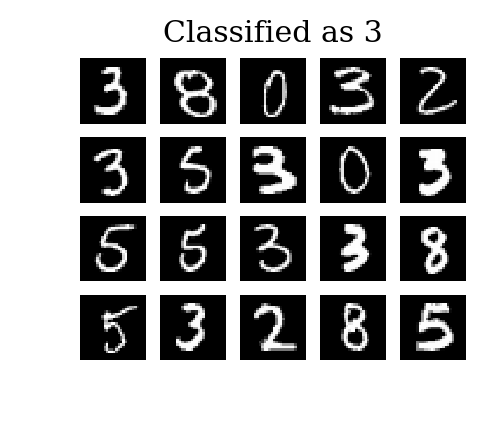

In [33]:
clust_2 = (data_train[(labels_10==1)])[0:20,:]

nrows = 4
ncols = 5

plt.figure(figsize=(ncols*0.5, nrows*0.5))

for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 3")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_2[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

- Third cluster, majority label "6" 

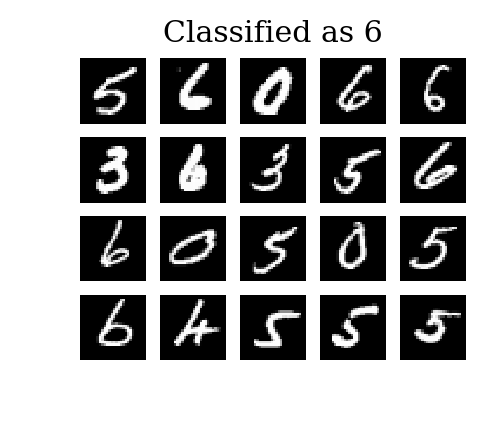

In [34]:
clust_3 = (data_train[(labels_10==2)])[0:20,:]

nrows = 4
ncols = 5

plt.figure(figsize=(ncols*0.5, nrows*0.5))

for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 6")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_3[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

 - Forth cluster, classified as "6"

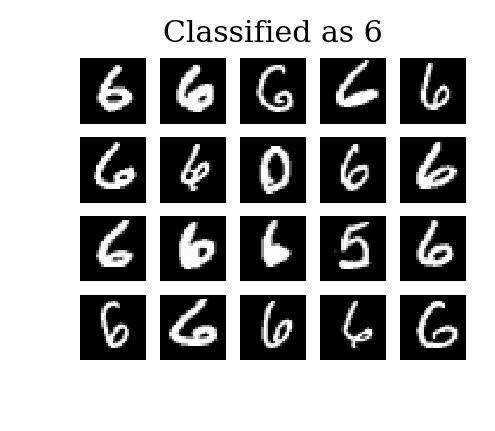

In [35]:
clust_4 = (data_train[(labels_10==3)])[0:20,:]

plt.figure(figsize=(ncols*0.5, nrows*0.5))

for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 6")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_4[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

 - Fifth cluster, classified as "0"

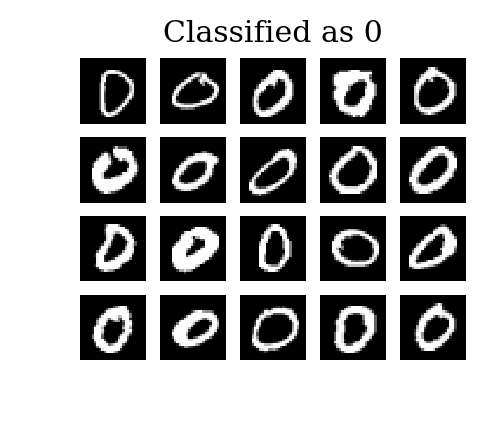

In [36]:
clust_5 = (data_train[(labels_10==4)])[0:20,:]

plt.figure(figsize=(ncols*0.5, nrows*0.5))

for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 0")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_5[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

 - Sixth cluster, classified as "1"

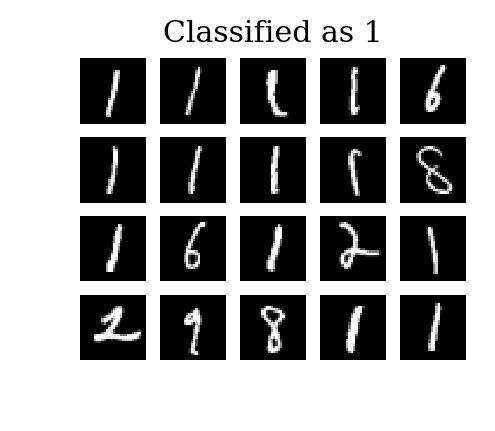

In [37]:
clust_6 = (data_train[(labels_10==5)])[0:20,:]

plt.figure(figsize=(ncols*0.5, nrows*0.5))

for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 1")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_6[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

- Seventh cluster, classified as "4"

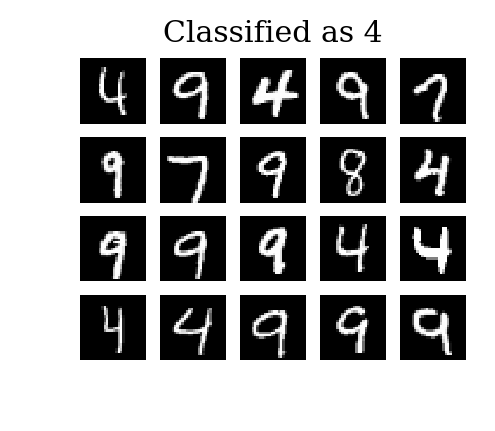

In [38]:
clust_7 = (data_train[(labels_10==6)])[0:20,:]

plt.figure(figsize=(ncols*0.5, nrows*0.5))

for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 4")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_7[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

- Eighth cluster, classified as "8"

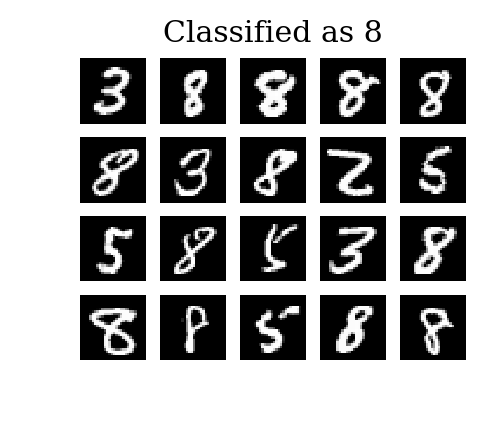

In [39]:
clust_8 = (data_train[(labels_10==7)])[0:20,:]

plt.figure(figsize=(ncols*0.5, nrows*0.5))

for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 8")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_8[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

- Ninth cluster, classified as "2"

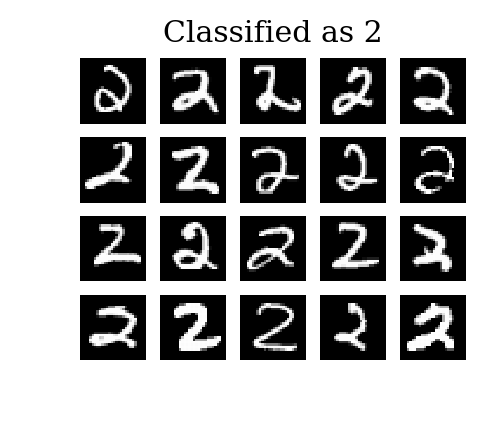

In [30]:
clust_9 = (data_train[(labels_10==8)])[0:20,:]

plt.figure(figsize=(ncols*0.5, nrows*0.5))

for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 2")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_9[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

- Tenth cluster, classified as "1"

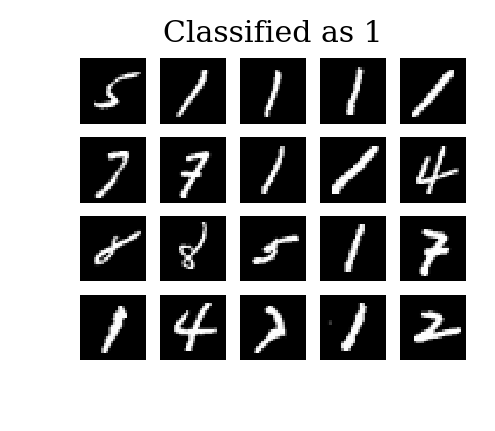

In [40]:
clust_10 = (data_train[(labels_10==9)])[0:20,:]

plt.figure(figsize=(ncols*0.5, nrows*0.5))

for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 1")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_10[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

## Part 3: Spectral clustering

In [156]:
# First construct similarity matrix
def sim_mat(X_mat, h):
    """
    Function that returns the similarity matrix W_{ij}
    
    Inputs:
    Matrix n x m, where : n, number of points, m number of features
    h : bandwidth
    """
    
    m = len(X_mat[:,0])
    
    # Initialize matrix
    W_mat = np.zeros([m,m])
    
    for i in range(m):
        for j in range(i,m):
            if (i==j):
                # Diagonal elements remain zero
                W_mat[i,j] = 0.0
            else:
                x_i = X_mat[i,:]
                x_j = X_mat[j,:]
                diff = x_i - x_j
                dist = np.matmul(diff.T,diff)
                W_mat[i,j] = np.exp(-dist/h)
                # Now take advantage of the fact that W is symmetric
                W_mat[j,i] = W_mat[i,j]
                
    return W_mat

In [157]:
# Write now function that takes the feture matrix and returns the normalized 
# Graph Laplacian matrix

def Laplacian(X_mat, h):
    """
    Function that calculates the normalized Graph Laplacian
    Inputs:
    Matrix n x m, where : n, number of points, m number of features
    h : bandwidth
    """
    # Get the similarity matrix using the above function
    W_mat = sim_mat(X_mat, h)

    # Construct the diagonal matrix D
    # Actually, I will directly get the D^{-1/2}
    # This has dimensions mxm
    
    # Get m
    m = len(W_mat[0,:])
    
    # Initialize square D^{-1/2} matrix 
    # and identity matrix
    sqrD = np.zeros([m,m])
    Ident = np.zeros([m,m])
    
    for i in range(m):
        # Get W_ij
        W_ij = W_mat[i,:]
        D_ii = np.sum(W_ij)
        sqrD[i,i] = (D_ii)**(-0.5)
        Ident[i,i] = 1.0
        
    
    # Construct Laplacian
    Lap = Ident - np.matmul(sqrD,(np.matmul(W_mat,sqrD)))
    
    
    #return Lagrangian
    return Lap    

In [158]:
# Let's work with just the first 4000 digits of the train set
# It was taking too much time for larger samples
data_first = data_train[0:4000,:]
labels_first = labels_train[0:4000,:]


# Get Laplacian matrix, for h = 25
h = 25.0

L_mat = Laplacian(data_first, h)

Now we have the graph laplacian matrix. We will get the 10 lowest (disregarding the lowest) eigenvectors.

We will construct a matrix $V$ with columns the eigenvectors $v_1, v_2, \dots, v_10$.

Will use this matrix as a feature matrix, and perform $k-$means clustering with $10$ clusters.

In [159]:
eig_values, eig_vectors = np.linalg.eig(L_mat)

print(eig_values[0:50])

[-6.63273798e-17  5.48886078e-01  6.21962695e-01  6.98081813e-01
  7.12414936e-01  7.31235306e-01  7.51289317e-01  7.94107786e-01
  8.13950360e-01  8.23485366e-01  8.27091694e-01  8.38450398e-01
  8.44208721e-01  8.49802580e-01  8.62316180e-01  8.70254040e-01
  8.71474744e-01  8.84084530e-01  8.90108169e-01  8.92412019e-01
  8.97704224e-01  8.98588483e-01  9.00742896e-01  9.06552706e-01
  9.07692829e-01  9.13048483e-01  9.13213909e-01  9.15169577e-01
  9.17896707e-01  9.21641755e-01  9.23513901e-01  9.23909651e-01
  9.27316018e-01  9.27264406e-01  9.29302858e-01  9.31704738e-01
  9.33931026e-01  9.34537307e-01  9.36583508e-01  9.37403568e-01
  9.38311042e-01  9.40280171e-01  9.40921552e-01  9.43038216e-01
  9.43734046e-01  9.44410477e-01  9.46659772e-01  9.46738255e-01
  9.47585738e-01  9.48063915e-01]


We now keep the first 10 eigenvectors (except the lowest that corresponds to $\lambda = 0$)

In [160]:
eig_vecs_10 = (eig_vectors.T)[1:11]

eig_vecs_10 = eig_vecs_10.T

print(np.shape(eig_vecs_10))

(4000, 10)


Perform $k$-means clustering now, with $k=10$.

In [161]:
k_means = KMeans(10)

# Train and predict labels
labels = k_means.fit_predict(eig_vecs_10)

# Now assign labels to each cluster according to the majority label

# Find majority label. Initialize
major_l = np.zeros(10)

for i in range(10):
    # Get the labels of the training set of 
    # the elements classified as belonging to the i-th cluster
    y_labels = labels_first[(labels==i)]
    major_l[i] = majority(y_labels)

#Print majority labels
print major_l

[0. 8. 2. 1. 3. 1. 4. 0. 6. 7.]


Although I tried different values of $h$ and checked the code again and again, I didn't manage to get 10 clusters with each one of them corresponding exactly to one of the digits $[0,\dots,9]$.

I was expecting spectral clustering to perform much better than k-means, but till now I don't see that from my implementation (bugs?). 

Anyway, let's check samples from the 10 clusters....

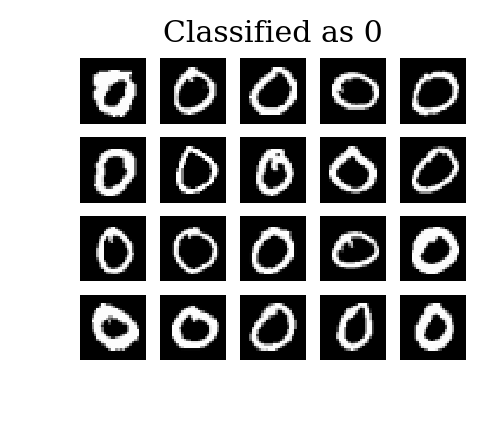

In [164]:
clust_1 = (data_first[(labels==0)])[0:20,:]

plt.figure(figsize=(ncols*0.5, nrows*0.5))
nrows = 4
ncols = 5

for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 0")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_1[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

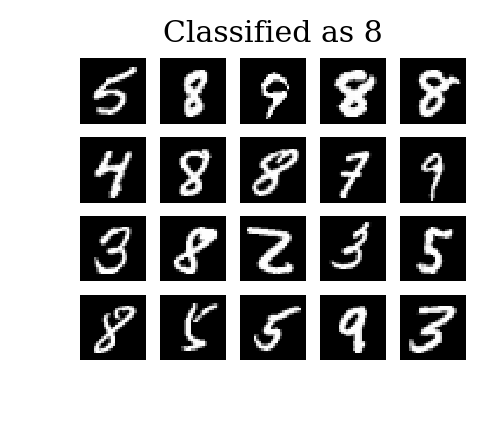

In [166]:
clust_2 = (data_first[(labels==1)])[0:20,:]

plt.figure(figsize=(ncols*0.5, nrows*0.5))

for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 8")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_2[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

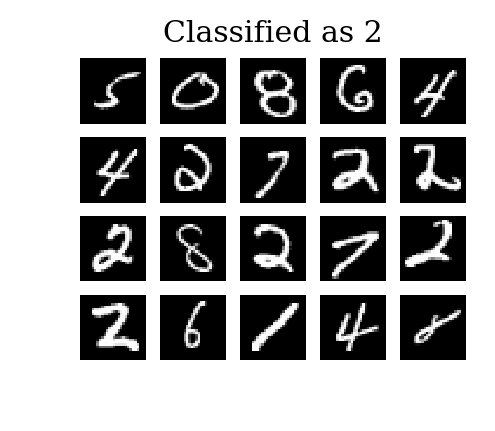

In [167]:
clust_3 = (data_first[(labels==2)])[0:20,:]
plt.figure(figsize=(ncols*0.5, nrows*0.5))
for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 2")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_3[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

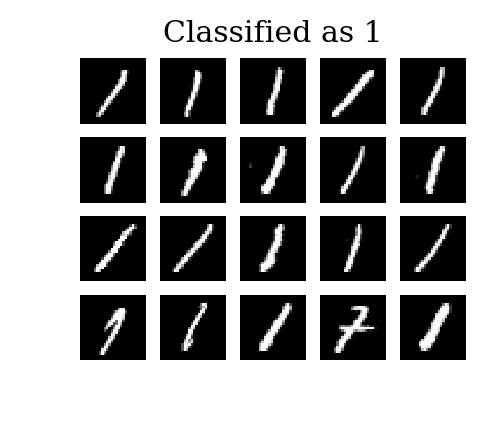

In [168]:
clust_4 = (data_first[(labels==3)])[0:20,:]
plt.figure(figsize=(ncols*0.5, nrows*0.5))
for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 1")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_4[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

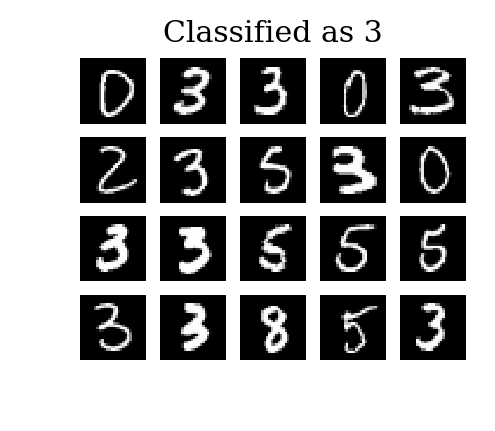

In [169]:
clust_5 = (data_first[(labels==4)])[0:20,:]
plt.figure(figsize=(ncols*0.5, nrows*0.5))
for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 3")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_5[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

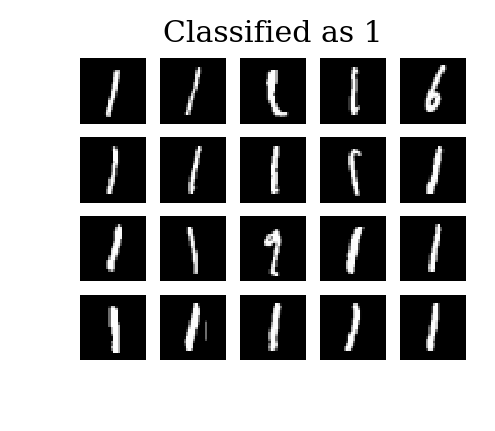

In [176]:
clust_6 = (data_first[(labels==5)])[0:20,:]
plt.figure(figsize=(ncols*0.5, nrows*0.5))
for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 1")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_6[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

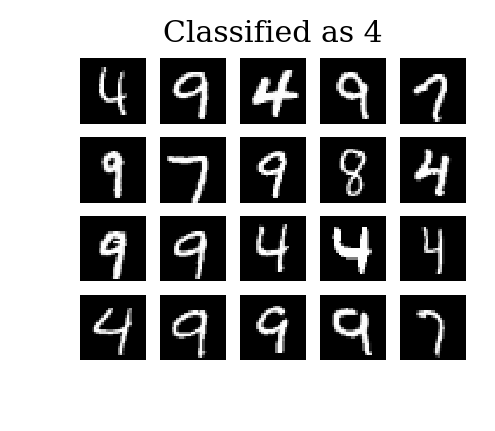

In [177]:
clust_7 = (data_first[(labels==6)])[0:20,:]
plt.figure(figsize=(ncols*0.5, nrows*0.5))
for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 4")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_7[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

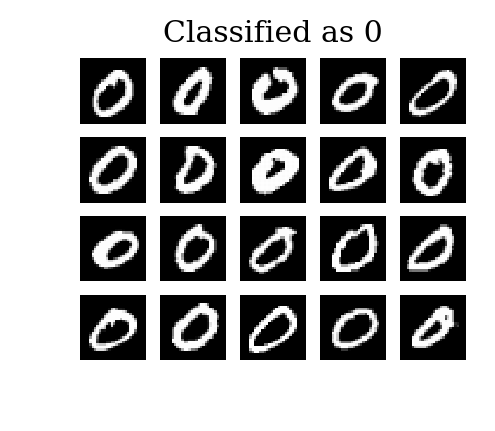

In [178]:
clust_8 = (data_first[(labels==7)])[0:20,:]
plt.figure(figsize=(ncols*0.5, nrows*0.5))
for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 0")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_8[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

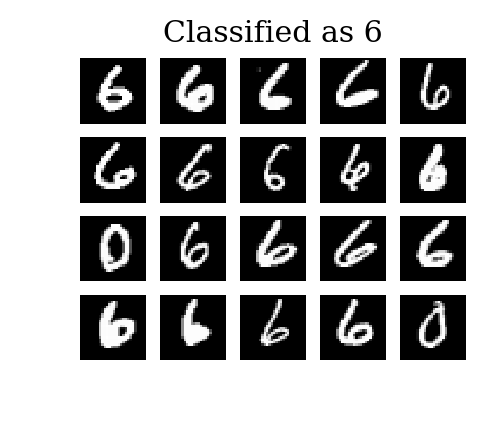

In [179]:
clust_9 = (data_first[(labels==8)])[0:20,:]
plt.figure(figsize=(ncols*0.5, nrows*0.5))
for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 6")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_9[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

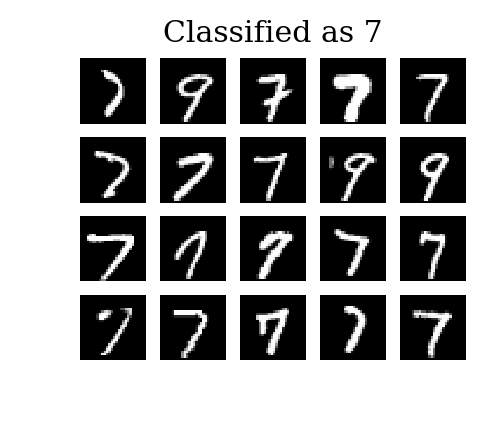

In [180]:
clust_10 = (data_first[(labels==9)])[0:20,:]
plt.figure(figsize=(ncols*0.5, nrows*0.5))
for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 7")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(clust_10[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

Comparing with the simple $k$-means clustering, we see that there is some improvement in some cases, but it fails in others (for example, the classification as "3" contains many "5"s as well). Probably the algorithm can be improved (choice of $h$, choice of dimensions kept in the dimensionality reduction), but some exploration I did, did not end into better results.

## Part 4: Classification

### (a) Multinomial logistic regression

In [188]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(fit_intercept=True, C=100000, penalty='l2',
                       multi_class='multinomial', solver='lbfgs')


# Fit the training set 
lg.fit(data_train, labels_train)

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

Error rate = $\frac{FN + FP}{TP+TN+FP+FN}$ = 1 - accuracy

Let's calculate accuracy and error rate on the development set.

In [189]:
# Predict labels for the development set
y_predict = lg.predict(data_devel)

In [191]:
# Import metrics 
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_predict, labels_devel))
print("Error rate:", 1-accuracy_score(y_predict, labels_devel))

('Accuracy:', 0.9215714285714286)
('Error rate:', 0.0784285714285714)


The error rate is $\sim 7.8 \%$.

We saw earlier that the harder to classify was probably the digit "5". Let's get a sample of digits classified as 5 and see how our classifier performs.

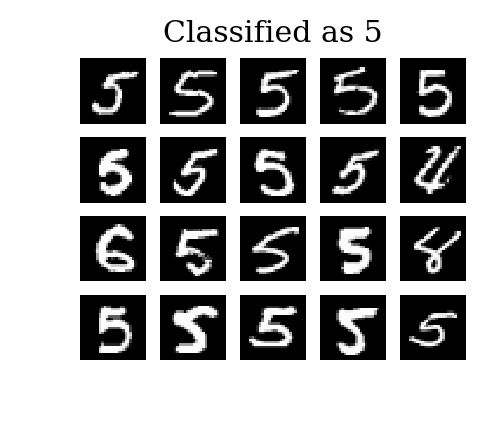

In [192]:
data_five = (data_devel[(y_predict==5)])[0:20,:]

plt.figure(figsize=(ncols*0.5, nrows*0.5))
for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 5")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(data_five[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

Very well!

### PCA and classification

### (b)

In [262]:
# Get the eigenvectors matrix from part 1 
# This matrix has the eigenvectors as its rows
#Principal components
PCs_train = eigen_vec_mat

#Now prepare here a similar matrix of eigenvectros for the development set

# Subtract the means
data_devel_new = np.zeros((14000,784))
data_dev_means = np.zeros(784)
for i in range(784):
    data_dev_means[i] = np.sum(data_devel[:,i])/14000.0
    data_devel_new[:,i] = data_devel[:,i] - data_dev_means[i]

# ===================================================
# Get the covariance matrix
cov_mat_devel = np.cov(data_devel_new.T)

# Get eigenvectors - eigenvalues
eig_vals_devel, eig_vecs_devel = np.linalg.eig(cov_mat_devel)

#Principal components
PCs_devel = eig_vecs_devel.T

In [263]:
def error_rate(k):
    """
    This function trains a multinomial logistic regression 
    keeping the first k Principal components of the training set.
    
    Then predicts the labels on the development set,
    calculates accuracy score and error rate and returns that
    k >= 1
    """
    # Get k first PCs from the train set - project 
    # U matrix 
    U_k_tr = (PCs_train[0:k]).T
    # Projection matrix
    P_k_tr = np.matmul(U_k_tr, U_k_tr.T)
    
    # Construct means matr
    means_tr = np.ones([42000,784])
    means_tr[:,:] = data_means
    means_tr = means_tr.T
    
    
    # Project-deproject
    k_PCs_train = np.matmul(P_k_tr, data_train_new.T) + means_tr
    k_PCs_train = k_PCs_train.T
    # Train logistic regression on that
    lg.fit(k_PCs_train, labels_train)
    
    # Get k first PCs from the development set
    # U matrix 
    U_k_devel =  (PCs_devel[0:k]).T
    # Projection matrix
    P_k_devel = np.matmul(U_k_devel, U_k_devel.T)
    
    # Construct means matr
    devel_means = np.ones([14000,784])
    devel_means[:,:] = data_dev_means
    devel_means = devel_means.T
    
    # Project-deproject
    k_PCs_devel = np.matmul(P_k_devel,data_devel_new.T) + devel_means
    k_PCs_devel = k_PCs_devel.T
    # Predict labels of the development set
    pred_devel = lg.predict(k_PCs_devel)
    
    # Calculate accuracy and error rate 
    error_rate = 1.0 - accuracy_score(pred_devel, labels_devel)
    
    return error_rate
    
    

Now, check in the range [1,100] first Principal components (after that, PCs are not very informative, as we saw in the first part). Calculate every 4 points for time efficiency...

In [267]:
# Vector of PCs to test
PCs_vector = np.arange(1,101,4)

# Vector to get error rates - initialize
Error_rates = np.zeros(len(PCs_vector))

# Populate now
for i in range(len(PCs_vector)):
    k = PCs_vector[i]
    Error_rates[i] = error_rate(k)

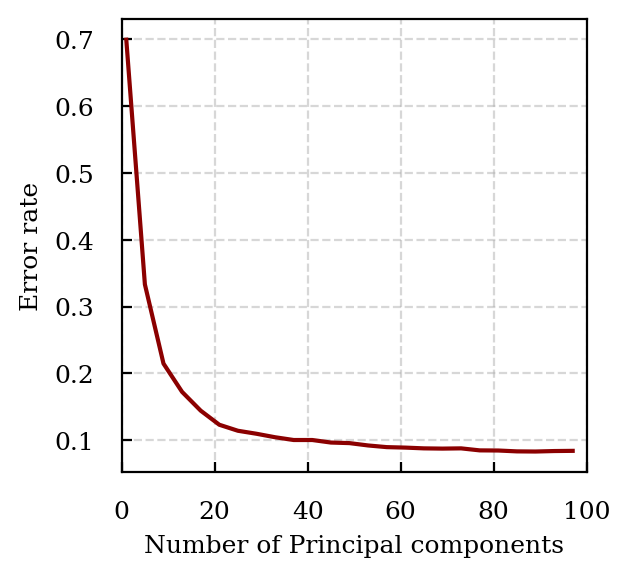

In [269]:
plt.figure(figsize=(3, 3))

plt.plot(PCs_vector, Error_rates, c = 'darkred')
plt.xlim(0,100)
plt.grid(ls='--',alpha=0.5)
plt.xlabel('Number of Principal components');plt.ylabel('Error rate')

plt.show()

In [272]:
print(Error_rates)

[0.69921429 0.33314286 0.21464286 0.17228571 0.14421429 0.12314286
 0.11414286 0.10964286 0.10442857 0.10028571 0.10028571 0.0965
 0.09564286 0.09214286 0.08964286 0.08892857 0.08778571 0.08742857
 0.08778571 0.08478571 0.08457143 0.08328571 0.08307143 0.08378571
 0.08407143]


In [274]:
i = np.where(Error_rates==np.min(Error_rates))
print(PCs_vector[i])

[89]


We have minimum error rate for $89 \sim 90$ Principal components.
Generally we see that the error rate is pretty high when just a few components are kept, bus stabilizes after $\sim 80-90$ components, at an error rate around $8 \%$.

### (c)

I will use $k = 90$.

In [285]:
data_combined = np.concatenate((data_train,data_devel))
labels_combined = np.concatenate((labels_train, labels_devel))

data_combined_new = np.zeros((56000,784))
means_combined = np.zeros(784)
for i in range(784):
    means_combined[i] = np.sum(data_combined[:,i])/14000.0
    data_combined_new[:,i] = data_combined[:,i] - means_combined[i]

# ===================================================
# Get the covariance matrix
cov_mat_combined = np.cov(data_combined_new.T)

# Get eigenvectors - eigenvalues
eig_vals_combined, eig_vecs_combined = np.linalg.eig(cov_mat_combined)

#Principal components
PCs_combined = eig_vecs_combined.T




print(np.shape(data_combined))

(56000, 784)


Find PCs for the test data

In [286]:
# Subtract the means
data_test_new = np.zeros((14000,784))
data_test_means = np.zeros(784)
for i in range(784):
    data_test_means[i] = np.sum(data_test[:,i])/14000.0
    data_test_new[:,i] = data_test[:,i] - data_test_means[i]

# ===================================================
# Get the covariance matrix
cov_mat_test = np.cov(data_test_new.T)

# Get eigenvectors - eigenvalues
eig_vals_test, eig_vecs_test = np.linalg.eig(cov_mat_test)

#Principal components
PCs_test = eig_vecs_test.T

Train, predict and calculate error rate

In [289]:
# Get 90 first PCs from the train set - project 
# U matrix 
U_90_tr = (PCs_combined[0:90]).T
# Projection matrix
P_90_tr = np.matmul(U_90_tr, U_90_tr.T)
    
# Construct means matr
means_tr = np.ones([56000,784])
means_tr[:,:] = means_combined
means_tr = means_tr.T
    
    
# Project-deproject
k_PCs_train = np.matmul(P_90_tr, data_combined.T) + means_tr
k_PCs_train = k_PCs_train.T
# Train logistic regression on that
lg.fit(k_PCs_train, labels_combined)
    
# Get 90 first PCs from the test set
# U matrix 
U_90_test =  (PCs_test[0:90]).T
# Projection matrix
P_90_test = np.matmul(U_90_test, U_90_test.T)
    
# Construct means matr
test_means = np.ones([14000,784])
test_means[:,:] = data_test_means
test_means = test_means.T
    
# Project-deproject
k_PCs_test = np.matmul(P_90_test,data_test_new.T) + test_means
k_PCs_test = k_PCs_test.T
# Predict labels of the development set
pred_test = lg.predict(k_PCs_test)
    
# Calculate accuracy and error rate 
error_rate = 1.0 - accuracy_score(pred_test, labels_test)
    

In [290]:
print("The error rate is:", error_rate)

('The error rate is:', 0.132)


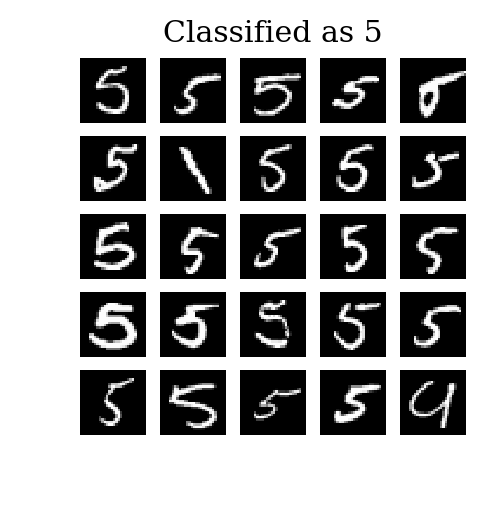

In [292]:
data_five = (data_test[(pred_test==5)])[0:25,:]

nrows = 5
plt.figure(figsize=(ncols*0.5, nrows*0.5))
for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("Classified as 5")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(data_five[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()